In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import os
import time
import pickle
import h5py
import joblib
import lenstronomy.Util.util as util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util import mask_util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Util.util import array2image
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Plots import  plot_util
import paramiko
from astropy.io import fits
from lenstronomy.Plots.model_plot import ModelPlot
#from chainconsumer import Chain, ChainConsumer, PlotConfig
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel


cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

Base directory path: /Users/rodrigoc/Documents/AGEL/Duncan_examples/model_notebooks


In [9]:
# =============================================================================
# PARAMETER RELOADING SYSTEM
# =============================================================================
# This cell reloads model parameters from the external script
# Run this cell whenever you want to update parameters from model_parameters.py

import importlib
import sys
import os

# Add the current directory to Python path
sys.path.insert(0, '/Users/rodrigoc/Documents/AGEL/Duncan_examples')

def model_update():
    # Import or reload the model parameters
    try:
        import model_parameters_base_DSPL_mock1 as mp
        # Force reload to get latest changes
        importlib.reload(mp)
        print("✅ Model parameters reloaded successfully!")
        
        # Load all parameters into local namespace for easy access
        globals().update({
            #models
            'mp': mp,
            # Cosmology
            'cosmo': mp.cosmo,
            'z_l': mp.z_l,
            'z_s1': mp.z_s1,
            'z_s2': mp.z_s2,
            'lens_redshift_list': mp.lens_redshift_list,
            'source_redshift_list': mp.source_redshift_list,
            
            # Coordinate parameters
            'lens_center_ra': mp.lens_center_ra,
            'lens_center_dec': mp.lens_center_dec,
            'lens_bound': mp.lens_bound,
            'source_bound': mp.source_bound,
            
            # Model lists
            'lens_model_list': mp.lens_model_list,
            'lens_light_model_list': mp.lens_light_model_list,
            'source_model_list': mp.source_model_list,
            'point_source_list': mp.point_source_list,
            'image_plane_source_list': mp.image_plane_source_list,
            
            # Parameter sets
            'lens_params': mp.lens_params,
            'lens_light_params': mp.lens_light_params,
            'source_params': mp.source_params,
            'ps_params': mp.ps_params,
            
            # Initial values for easy access
            'kwargs_lens_init': mp.kwargs_lens_init,
            'kwargs_lens_sigma': mp.kwargs_lens_sigma,
            'kwargs_lens_fixed': mp.kwargs_lens_fixed,
            'kwargs_lower_lens': mp.kwargs_lower_lens,
            'kwargs_upper_lens': mp.kwargs_upper_lens,
            
            'kwargs_lens_light_init': mp.kwargs_lens_light_init,
            'kwargs_lens_light_sigma': mp.kwargs_lens_light_sigma,
            'kwargs_lens_light_fixed': mp.kwargs_lens_light_fixed,
            'kwargs_lower_lens_light': mp.kwargs_lower_lens_light,
            'kwargs_upper_lens_light': mp.kwargs_upper_lens_light,
            
            'kwargs_source_init': mp.kwargs_source_init,
            'kwargs_source_sigma': mp.kwargs_source_sigma,
            'kwargs_source_fixed': mp.kwargs_source_fixed,
            'kwargs_lower_source': mp.kwargs_lower_source,
            'kwargs_upper_source': mp.kwargs_upper_source,
            
            # Masking parameters
            'central_mask': mp.central_mask,
            'central_mask_r': mp.central_mask_r,
            'r_mask_list': mp.r_mask_list,
            'threshold_list': mp.threshold_list,
            
            # Functions
            'custom_logL_function': mp.custom_logL_function,
            
            # Build the main model configuration
            'kwargs_model' : mp.get_model_config(),

            # Build parameter configuration
            'kwargs_params': mp.get_all_model_params(),

            # Build constraints (this will be updated later with mask information)
            'kwargs_constraints': mp.get_constraints(),

            # Build likelihood configuration
            'kwargs_likelihood': mp.get_likelihood_config(),

            # Build initial model state for fitting
            'kwargs_model_init': {
                'kwargs_lens': mp.kwargs_lens_init,
                'kwargs_source': mp.kwargs_source_init,
                'kwargs_lens_light': mp.kwargs_lens_light_init,
                'kwargs_ps': mp.kwargs_ps_init,
                'kwargs_special': {}, 
                'kwargs_extinction': {}, 
                'kwargs_tracer_source': {}
            }


        })

        
        # Print current parameters for verification
        mp.print_current_params()
    
    except ImportError as e:
        print(f"❌ Failed to import model_parameters: {e}")
        print("Make sure model_parameters.py exists in the Duncan_examples directory")
    except Exception as e:
        print(f"❌ Error reloading parameters: {e}")

    
    print("✅ Model configurations built successfully!")
    print(f"📊 Model includes:")
    print(f"   - Lens models: {len(lens_model_list)} ({', '.join(lens_model_list)})")
    print(f"   - Source models: {len(source_model_list)} ({', '.join(source_model_list)})")
    print(f"   - Lens light models: {len(lens_light_model_list)} ({', '.join(lens_light_model_list)})")
    print(f"   - Multi-plane: {kwargs_model.get('multi_plane', False)}")
    print(f"   - Redshifts: z_l={z_l}, z_s1={z_s1}, z_s2={z_s2}")

    # Verify parameter access
    print(f"\n🔍 Quick parameter check:")
    print(f"   - Einstein radius: {kwargs_lens_init[0]['theta_E']:.4f}")
    print(f"   - Lens center: ({kwargs_lens_init[0]['center_x']:.6f}, {kwargs_lens_init[0]['center_y']:.6f})")
    print(f"   - Shear: gamma_ext={kwargs_lens_init[1]['gamma_ext']:.4f}, psi_ext={kwargs_lens_init[1]['psi_ext']:.4f}")


    print("\n🔄 Run this cell/function anytime to reload parameters from model_parameters.py")


model_update()

✅ Model parameters reloaded successfully!
CURRENT MODEL PARAMETERS
Lens center: (0.097892, 0.020404)
Redshifts - Lens: 0.5, Source 1: 0.8, Source 2: 1.7
Einstein radius: 1.7124
❌ Error reloading parameters: 'gamma1'
✅ Model configurations built successfully!
📊 Model includes:
   - Lens models: 3 (SIE, SHEAR_GAMMA_PSI, SIE)
   - Source models: 2 (SERSIC_ELLIPSE, SERSIC_ELLIPSE)
   - Lens light models: 1 (SERSIC_ELLIPSE)
   - Multi-plane: True
   - Redshifts: z_l=0.5, z_s1=0.8, z_s2=1.7

🔍 Quick parameter check:
   - Einstein radius: 1.7124
   - Lens center: (0.037892, -0.140404)
   - Shear: gamma_ext=0.1192, psi_ext=0.5038

🔄 Run this cell/function anytime to reload parameters from model_parameters.py


In [10]:
kwargs_source_init

[{'R_sersic': 0.2035989518818442,
  'n_sersic': 1.8792552215500815,
  'e1': 0.4371870389197965,
  'e2': -0.10569696047809995,
  'center_x': -0.029117910235873692,
  'center_y': -0.006857098975273035},
 {'R_sersic': 0.11098111524947607,
  'n_sersic': 0.5251575461491514,
  'e1': 0.497834080242937,
  'e2': -0.11661295352147125,
  'center_x': 0.372622796607731,
  'center_y': 0.12008851104310789}]

In [11]:
def import_data(file_path):

    kwargs_data = {}
    
    data_file = os.path.join(base_path, '../'+file_path)
    f = fits.open(data_file)
    # storing data under correct keys
    kwargs_data.update({'image_data': f[0].data,
                        'background_rms': 0.004,
                        'exposure_time': 500.0*np.ones(shape=f[0].data.shape),
                        'ra_at_xy_0': -2.725,
                        'dec_at_xy_0': -2.725,
                        'transform_pix2angle': np.array([[0.05, 0.  ],
                                                        [0.  , 0.05]]),
                        'ra_shift': 0,
                        'dec_shift': 0})
    f.close()

    # get PSF estimate from fits
    psf_file = os.path.join(base_path, '../mocks/PSF/mock_psf.fits')
    f = fits.open(psf_file)
    kernel_point_source = f[0].data
    f.close()

    # format psf kwargs
    kwargs_psf = {'psf_type': "PIXEL", 
                'kernel_point_source': kernel_point_source ,
                'kernel_point_source_init': kernel_point_source ,
                }
    return kwargs_data, kwargs_psf



kwargs_data_F200LP, kwargs_psf_F200LP = import_data('mocks/images/mock_1_image.fits')

Pixel size: 0.05 arcsec
numPix: 110



/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_33883/204847585.py:28: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-3.8, vmax=0.5)


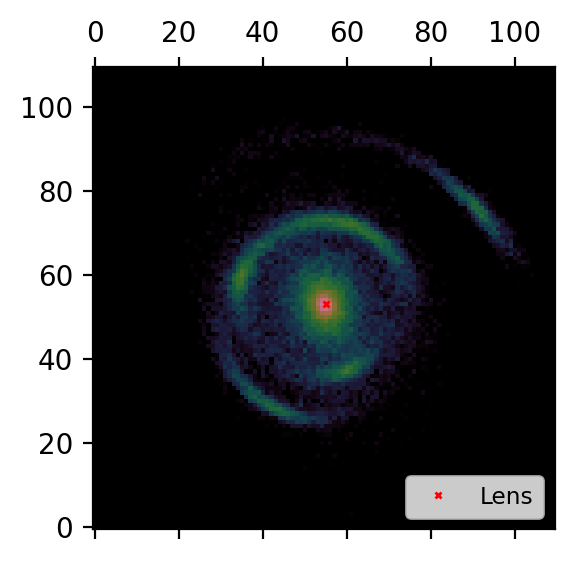

In [12]:
# read-in the coordiante system of the exposure
# ra_at_xy_0 = kwargs_data_F200LP['ra_at_xy_0']
# dec_at_xy_0 = kwargs_data_F200LP['dec_at_xy_0']
# transform_pix2angle = kwargs_data_F200LP['transform_pix2angle']
# coords_F200LP = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# For mock data:
 
# Data properties (use below values for mock images)
ra_at_xy_0 = -2.725
dec_at_xy_0 = -2.725
transform_pix2angle = np.array([[0.05, 0.  ],
                                [0.  , 0.05]])
coords_F200LP = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)


# read-in the reduced cutout image
image_data = kwargs_data_F200LP['image_data']
numPix = len(image_data)
deltaPix = coords_F200LP.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
print()

cmap = sns.cubehelix_palette(start=0.6, rot=-1.7, gamma=1, hue=1, light=-.7, dark=0.7, as_cmap=True)
cmap.set_bad(color='k')
ax = plt.figure(figsize=(3,3), dpi=200).gca()
ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-3.8, vmax=0.5)

kwargs_pixel_F200LP = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid_F200LP = PixelGrid(**kwargs_pixel_F200LP)
# plot_util.coordinate_arrows(ax, d=200, coords=pixel_grid, color='red', font_size=18, arrow_size=0.035)


lens_x_F200LP, lens_y_F200LP = 55, 53
lens_ra_F200LP, lens_dec_F200LP = coords_F200LP.map_pix2coord(lens_x_F200LP, lens_y_F200LP)
ax.plot(lens_x_F200LP, lens_y_F200LP, 'x', color='red', ms = 2, label='Lens') 

# # estimate lens position in pixel
# lens_x_F200LP, lens_y_F200LP = 57, 55
# lens_ra_F200LP, lens_dec_F200LP = coords_F200LP.map_pix2coord(lens_x_F200LP, lens_y_F200LP)
# ax.plot(lens_x_F200LP, lens_y_F200LP, 'x', color='red', ms = 2, label='Lens') 

# # estimate source 1 positions in pixel
# s1_x_F200LP = np.array([87,12,88,46])#,77])
# s1_y_F200LP = np.array([95,78,51,35])#,100])
# ra_image_s1_F200LP, dec_image_s1_F200LP = coords_F200LP.map_pix2coord(s1_x_F200LP, s1_y_F200LP)
# ax.plot(s1_x_F200LP, s1_y_F200LP, 'o', color='lime', ms = 2, label='Lensed source 1')

# # estimate source 2 positions in pixel
# s2_x_F200LP = np.array([100,35,62,43])
# s2_y_F200LP = np.array([65,31,93.5,93])
# ra_image_s2_F200LP, dec_image_s2_F200LP = coords_F200LP.map_pix2coord(s2_x_F200LP, s2_y_F200LP)
# ax.plot(s2_x_F200LP, s2_y_F200LP, 'o', color='magenta', ms = 2, label='Lensed source 2')

# # estimate galaxy position in pixel
# gal1_x_F200LP, gal1_y_F200LP = 77, 8
# gal1_ra_F200LP, gal1_dec_F200LP = coords_F200LP.map_pix2coord(gal1_x_F200LP, gal1_y_F200LP)
# ax.plot(gal1_x_F200LP, gal1_y_F200LP, 'x', color='cyan', ms = 2, label='Galaxy 1') 

plt.legend(loc='lower right', fontsize='small')
plt.show()

/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_33883/3092833279.py:24: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap='magma')


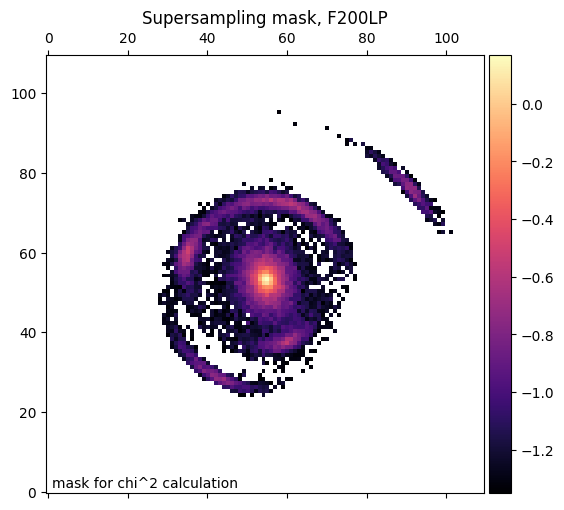

In [38]:
# pixels with flux > max_flux/threshold will not be supersampled
# here the threshold accepts pixels within 5 magnitude from the pixel with max_flux
threshold_list = [10**(3.8/2.5)]

supersampling_mask = []

for j, kwargs_data in enumerate([kwargs_data_F200LP]):
    s_mask = np.ones_like(kwargs_data['image_data'])
    
    max_flux = np.max(kwargs_data['image_data'])
    s_mask[kwargs_data['image_data'] < max_flux/threshold_list[j]] = 0
    
    supersampling_mask.append(s_mask)

filters = ['F200LP']

for j, kwargs_data in enumerate([kwargs_data_F200LP]):
    image = kwargs_data['image_data']
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    mask = supersampling_mask[j]#*mask_list[0][j]
    im = ax.matshow(np.log10(image*mask), origin='lower', cmap='magma')
    ax.text(1, 1, 'mask for chi^2 calculation')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Supersampling mask, "+filters[j])
    plt.colorbar(im, cax=cax)

    plt.show()

In [39]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05)


D_s1 = cosmo.angular_diameter_distance(z_s1).value
D_s2 = cosmo.angular_diameter_distance(z_s2).value
D_s1s2 = cosmo.angular_diameter_distance_z1z2(z_s1, z_s2).value
D_ls1 = cosmo.angular_diameter_distance_z1z2(z_l, z_s1).value
D_ls2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s2).value

#cosmological scaling factor=deflection_scaling= 1/β
deflection_scaling = D_s1 / D_ls1 * D_ls2 / D_s2  
beta=1/deflection_scaling
print('Angular diameter distance between s1 and s2: {} Mpc'.format(D_s1s2))
print('Deflection angle rescale factor: {:.6f}'.format(deflection_scaling))
print('Beta:{:.6f}'.format(beta))

Angular diameter distance between s1 and s2: 713.6636882255873 Mpc
Deflection angle rescale factor: 1.858580
Beta:0.538045


In [82]:
model_update()

lens_center_ra, lens_center_dec = lens_ra_F200LP, lens_dec_F200LP

# gal1_center_x, gal1_center_y = gal1_ra_F140W, gal1_dec_F140W
# gal_bound = 0.05

shapelet_beta = 0.15 # initial guess of the shapelet scale (in arcsec)

source_bound = 0.15 

kwargs_numerics = {'supersampling_factor':3,  # use 3 for final runs                              
                   'supersampling_convolution':True, 
                   'supersampling_kernel_size': 7,
                   'flux_evaluate_indexes': None,
                   'point_source_supersampling_factor': 3,  # use 3 for final runs
                   'compute_mode': 'adaptive',
                   'supersampled_indexes': np.array(supersampling_mask[0], dtype=bool)
                   }

num_source_model = len(source_model_list)

def custom_logL_function(kwargs_lens=None, kwargs_source=None, 
                                 kwargs_lens_light=None, kwargs_ps=None, 
                                 kwargs_special=None, kwargs_extinction=None,
                                 kwargs_tracer_source=None):
    """
    Addition custom term to add to log likelihood function.
    """
    
    logL = 0.
    bound = 30. / 180. * np.pi

    # PA constraint
    # find e1 & e2 param., convert to PA (phi)
    mass_phi, mass_q = ellipticity2phi_q(kwargs_lens[0]['e1'], kwargs_lens[0]['e2'])
    light_phi, light_q = ellipticity2phi_q(kwargs_lens_light[0]['e1'], kwargs_lens_light[0]['e2'])

    # ellipticity prior to reduce disparity between mass and light
    if mass_q < light_q:  
        logL += -0.5 * (mass_q - light_q)**2 / 0.01**2
    logL += -0.5 * (mass_phi - light_phi)**2 / bound**2

    # lens centre prior
    lens_center_x, lens_center_y = 0.09789233337522507, 0.020403937171283193  # visually measured centre
    logL -= ((kwargs_lens[0]['center_x'] - lens_center_x)**2 + (kwargs_lens[0]['center_y'] - lens_center_y)**2)*10

    return logL

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': True,
                     'image_position_uncertainty': 0.001,
                     'image_position_likelihood':True,  # turn on for double source
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'bands_compute':[True],
                     'check_positive_flux':True,
                     #'image_likelihood_mask_list':  mask_list[0],
                     #'custom_logL_addition': custom_logL_function,
                     'astrometric_likelihood':True
                     }

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': True,
                     'image_position_uncertainty': 0.001,
                     'image_position_likelihood':True,  # turn on for double source
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'bands_compute':[True],
                     'check_positive_flux':True,
                     #'image_likelihood_mask_list':  mask_list[0],
                     'custom_logL_addition': custom_logL_function,
                     'astrometric_likelihood':True
                     }

F200LP_band = [kwargs_data_F200LP, kwargs_psf_F200LP, kwargs_numerics]
multi_band_list = [F200LP_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}



✅ Model parameters reloaded successfully!
CURRENT MODEL PARAMETERS
Lens center: (0.030000, -0.140404)
Redshifts - Lens: 0.5, Source 1: 0.8, Source 2: 1.7
Einstein radius: 1.7124
❌ Error reloading parameters: 'gamma1'
✅ Model configurations built successfully!
📊 Model includes:
   - Lens models: 3 (SIE, SHEAR_GAMMA_PSI, SIE)
   - Source models: 2 (SERSIC_ELLIPSE, SERSIC_ELLIPSE)
   - Lens light models: 1 (SERSIC_ELLIPSE)
   - Multi-plane: True
   - Redshifts: z_l=0.5, z_s1=0.8, z_s2=1.7

🔍 Quick parameter check:
   - Einstein radius: 1.7124
   - Lens center: (0.030000, -0.140404)
   - Shear: gamma_ext=0.1192, psi_ext=0.5038

🔄 Run this cell/function anytime to reload parameters from model_parameters.py


In [83]:
kwargs_constraints

{'image_plane_source_list': [False, False],
 'joint_lens_with_source_light': [[0,
   2,
   ['center_x', 'center_y', 'e1', 'e2']]]}

In [96]:
fitting_kwargs_list = [#['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True]}}],
                       #['PSO', {'sigma_scale': 10, 'n_particles': 220, 'n_iterations': 3000}],
                       ['PSO', {'sigma_scale': 5, 'n_particles': 100, 'n_iterations': 200}],
                       #['PSO', {'sigma_scale': 0.5, 'n_particles': 220, 'n_iterations': 2000}],
                       #['PSO', {'sigma_scale': 0.1, 'n_particles': 220, 'n_iterations': 2000}],
                       #['MCMC', {'n_burn': 100, 'n_run': 3000, 'walkerRatio': 6, 'sigma_scale': 0.5}]
                       ]

In [97]:
def configure_model(job_name, fitting_kwargs_list=fitting_kwargs_list, kwargs_params=kwargs_params, cluster_compute=False, use_good_start=False, prev_job_name=None, reuse_samples=False, prev_file_dir=None, verbose=False):   
    init_samples = None
    input_temp = job_name +'.txt'
    output_temp = job_name +'_out.txt'

    # load previous job result as starting point
    if use_good_start:

        if prev_job_name is None:
            raise ValueError
        job_name_old =  prev_job_name
        
        if prev_file_dir is None:
            raise ValueError
        
        output_temp_old = os.path.join(base_path, prev_file_dir, job_name_old +'_out.txt') #'local_temp'

        f = open(output_temp_old, 'rb')
        [input_, output_] = joblib.load(f)
        f.close()

        old_fitting_kwargs_list, kwargs_data_joint_out, _, _, _, _, _ = input_
        kwargs_result, multi_band_list_out, fit_output, _ = output_
        lens_result = kwargs_result['kwargs_lens']
        source_result = kwargs_result['kwargs_source']
        lens_light_result = kwargs_result['kwargs_lens_light']
        ps_result = kwargs_result['kwargs_ps']
        #special_result= kwargs_result['kwargs_special']

        # updating init kwargs
        lens_params[0] = update_init(lens_result, lens_params[0])       
        source_params[0] = update_init(source_result, source_params[0]) 
        lens_light_params[0] = update_init(lens_light_result, lens_light_params[0])
        ps_params[0] = update_init(ps_result, ps_params[0])
        #special_params[0] =special_result 
    
        # updating kwargs that will be input into fitting sequence
        kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params,
                    #'special': special_params
                    }
        
        if verbose:
            print('updated lens_params',lens_params)
            print('\n updated source_params',source_params)
            print('\n updated lens_light_params',lens_light_params)
            print('\n updated ps_params',ps_params)
            #print('\n updated special_params',special_params)
        
        # using prev mcmc sapmples for next mcmc
        if reuse_samples:
            samples_mcmc = fit_output[-1][1] #mcmc chain from prev_job_name
            
            n_params = samples_mcmc.shape[1]

            n_walkers = old_fitting_kwargs_list[-1][1]['walkerRatio'] * n_params
            n_step = int(samples_mcmc.shape[0] / n_walkers)

            print('MCMC settings from last chain: ', n_step, n_walkers, n_params)

            chain = np.empty((n_walkers, n_step, n_params))
            
            for i in np.arange(n_params):
                samples = samples_mcmc[:, i].T
                chain[:,:,i] = samples.reshape((n_step, n_walkers)).T
            
            init_samples = chain[:, -1, :]
            #print(np.shape(init_samples))
            #print(init_samples)
            print('Init MCMC samples from: ', prev_job_name)
            print('Init samples shape: ', init_samples.shape)
            
        else:
            init_samples = None

        # updating kwargs that will be input into fitting sequence  
        fitting_kwargs_list=[['update_settings', {'kwargs_likelihood': {'bands_compute': [True]}}],
                             #['PSO', {'sigma_scale': 0.1, 'n_particles': 250, 'n_iterations': 500}],
                        #['MCMC', {'n_burn': 100, 'n_run': 4000, 'walkerRatio': 8, 'sigma_scale': .1}]
                ['MCMC', {'n_burn': 0, #mcmc_n_burn, 
                          'n_run':3000, #mcmc_n_run, 
                          'walkerRatio': 6, 
                          'sigma_scale': 0.5,
                          're_use_samples': True, 
                          'init_samples': init_samples}]
                        ]
        if verbose:
            print('updated fitting_kwargs_list', fitting_kwargs_list)
    
    if cluster_compute is True:
        path2input_temp = os.path.join(base_path, 'midway_temp', input_temp)
        dir_path_cluster = '/pool/public/sao/dbowden/Compound/DCLS0353'
        path2input_cluster = os.path.join(dir_path_cluster, 'local_temp', input_temp)

        f = open(path2input_temp,'wb')
        pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
        f.close()
        time.sleep(2)

        # copying .txt to remote cluster with model and fitting info
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=None, username=None, password=None) 
        ftp_client = ssh_client.open_sftp()
        ftp_client.put(path2input_temp, path2input_cluster)
        ftp_client.put(base_path+'/jobs/DCLS0353_double_source_F200LP_V18.job', dir_path_cluster+'/DCLS0353_double_source_F200LP_V18.job')  # update job file before executing this
        ftp_client.close()
        ssh_client.close()

        print('File %s uploaded to cluster' %path2input_cluster)
        print('Must run job on cluster with jobname {} and job file {}'.format(job_name, job_name[:-7]+'.job'))
    else:
        path2input_temp = os.path.join(base_path, 'local_temp', input_temp)

        f = open(path2input_temp,'wb')
        pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
        f.close()
        time.sleep(2)

        start_time = time.time()
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False, verbose=True)
    
        fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result = fitting_seq.best_fit(bijective=False)
        multi_band_list_out = fitting_seq.multi_band_list
        
        kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs  
        #kwargs_fixed_out = fitting_seq.kwargs_fixed
        #param_class = fitting_seq.param_class
        output_ = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

        input_ = [fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
        path2dump = os.path.join(base_path, 'local_temp', output_temp)
        f = open(path2dump, 'wb')
        joblib.dump([input_, output_], f)
        f.close()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('Result saved in: %s' % path2dump)
        print('============ CONGRATULATIONS, YOUR JOB WAS SUCCESSFUL ================ ')

        return fitting_seq 

In [98]:
job_name = 'PSO_double_source_test'

cluster_comp = False

In [99]:
configure_model(job_name, cluster_compute=cluster_comp)

/Users/rodrigoc/opt/anaconda3/envs/lens_tutorial_duncan/lib/python3.13/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/Users/rodrigoc/opt/anaconda3/envs/lens_tutorial_duncan/lib/python3.13/site-packages/lenstronomy/LensModel/MultiPlane/multi_plane.py:76: UserWarning: Cosmology is provided. Make sure your cosmological model is consistent with the cosmology_model argument.
  warnings.warn(


Computing the PSO ...


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]

Max iteration reached! Stopping.
-1.1735485408656512 reduced X^2 of best position
-7082.952218394637 log likelihood
12071 effective number of data points
[{'theta_E': 1.7547256141249323, 'e1': -0.11614655684344428, 'e2': -0.050205824444721894, 'center_x': 0.006885412971899223, 'center_y': -0.09041513412952838}, {'gamma_ext': 4.3810807125896135e-06, 'psi_ext': 0.22128400840926274, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 2.5437373185135694e-05, 'e1': 0.17277700626519565, 'e2': -0.06945759813407523, 'center_x': -0.051131214811328866, 'center_y': 0.00894405414764441}] lens result
[{'amp': 1, 'R_sersic': 0.2303638270880491, 'n_sersic': 2.8556692057627844, 'e1': 0.17277700626519565, 'e2': -0.06945759813407523, 'center_x': -0.051131214811328866, 'center_y': 0.00894405414764441}, {'amp': 1, 'R_sersic': 0.1297600038897629, 'n_sersic': 1.2470121318099168, 'e1': 0.4069626428035062, 'e2': -0.37031526766730594, 'center_x': 0.27981682228484966, 'center_y': 0.17255083153838277}] source result
[{'amp': 1,

In [100]:
job_name_out = job_name+'_out.txt'  # 'DCLS0353_double_source_F200LP_V18_run_07_out.txt'

output_temp = os.path.join(base_path, 'local_temp', job_name_out)

path2dump = os.path.join(base_path, 'midway_temp', job_name_out)

if cluster_comp:

    if not os.path.exists(path2dump):  # If file does not exist, copy from cluster
        dir_path_cluster = '/pool/public/sao/dbowden/Compound/DCLS0353'
        path2dump_cluster = os.path.join(dir_path_cluster, 'local_temp', job_name_out)

        # copying results _out.txt from remote cluster
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=None, username=None, password=None) 
        ftp_client = ssh_client.open_sftp()
        ftp_client.get(path2dump_cluster, path2dump)
        ftp_client.close()
        ssh_client.close()

    f = open(path2dump, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    
else:    
    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()

fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

-1.1691307952698091 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.169130795269809


/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_33883/4109067388.py:2: RuntimeWarning: invalid value encountered in log10
  plot = ax.imshow(np.log10(data), origin='lower', cmap=c_map,vmin=v_min,vmax=v_max)


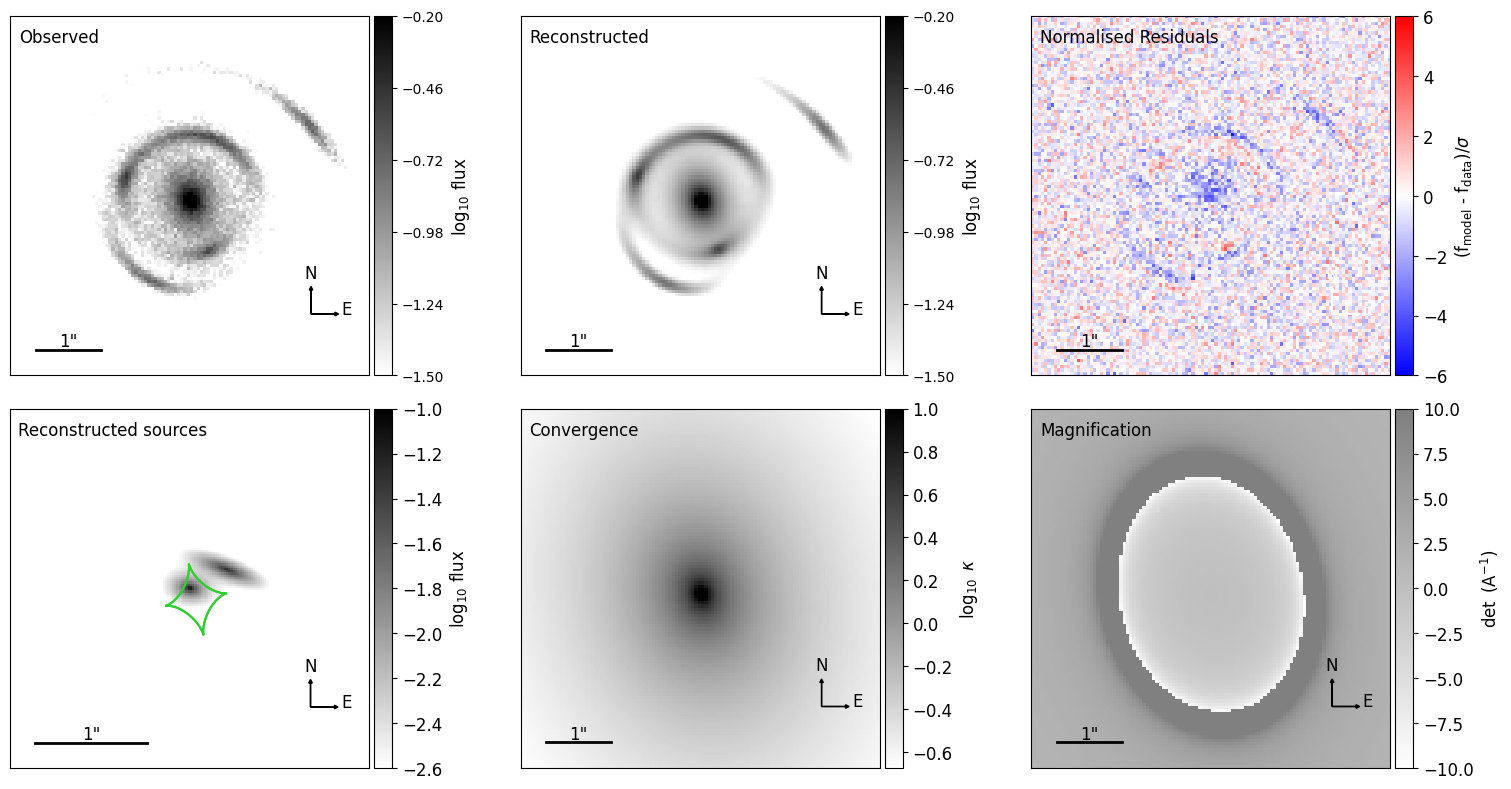

{'kwargs_lens': [{'theta_E': 1.7547256141249323,
   'e1': -0.11614655684344428,
   'e2': -0.050205824444721894,
   'center_x': 0.006885412971899223,
   'center_y': -0.09041513412952838},
  {'gamma_ext': 4.3810807125896135e-06,
   'psi_ext': 0.22128400840926274,
   'ra_0': 0,
   'dec_0': 0},
  {'theta_E': 2.5437373185135694e-05,
   'e1': 0.17277700626519565,
   'e2': -0.06945759813407523,
   'center_x': -0.051131214811328866,
   'center_y': 0.00894405414764441}],
 'kwargs_source': [{'amp': 5.563166958563405,
   'R_sersic': 0.2303638270880491,
   'n_sersic': 2.8556692057627844,
   'e1': 0.17277700626519565,
   'e2': -0.06945759813407523,
   'center_x': -0.051131214811328866,
   'center_y': 0.00894405414764441},
  {'amp': 17.99800997387111,
   'R_sersic': 0.1297600038897629,
   'n_sersic': 1.2470121318099168,
   'e1': 0.4069626428035062,
   'e2': -0.37031526766730594,
   'center_x': 0.27981682228484966,
   'center_y': 0.17255083153838277}],
 'kwargs_lens_light': [{'amp': 1.899751823215279

In [101]:
def arraytosubplot(ax, data, pixel_grid, pix2arcsec, imtype, v_min=-2, v_max=1, c_map='gray_r'):
    plot = ax.imshow(np.log10(data), origin='lower', cmap=c_map,vmin=v_min,vmax=v_max)
    ax.set_xticks([])
    ax.set_yticks([])
    divider1 = make_axes_locatable(ax)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cbar1 = plt.colorbar(plot, cax=cax1)
    cbar1.set_ticks(np.linspace(v_min,v_max,6))
    cbar1.ax.set_ylabel('log$_{10}$ flux', fontsize=12)
    plot_util.coordinate_arrows(ax, pixel_grid._nx, pixel_grid, color="k", arrow_size=0.01, font_size=12)
    plot_util.scale_bar(ax, pixel_grid._nx, dist=pix2arcsec, text='1"', font_size=12, color='k')
    plot_util.text_description(ax, pixel_grid._nx,text=imtype,color="k",backgroundcolor="w",font_size=12)
    return


from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                      arrow_size=0.01, cmap_string='gray_r',)
                      #image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list']
                      #)

#print(kwargs_model)
#print(kwargs_result)

f, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)

# data for custom plotting
image_data = kwargs_data_F200LP['image_data']
recon_F200LP = modelPlot._band_plot_list[0]._model
#source_recon = modelPlot.source(deltaPix=0.02, numPix=160, center=(kwargs_result['kwargs_lens'][0]['center_x'], kwargs_result['kwargs_lens'][0]['center_y']))

arraytosubplot(axes[0,0], image_data, pixel_grid_F200LP, 20, 'Observed', v_min=-1.5, v_max=-0.2)
arraytosubplot(axes[0,1], recon_F200LP, pixel_grid_F200LP, 20, 'Reconstructed', v_min=-1.5, v_max=-0.2)

# source = axes[1, 0].imshow(np.log10(source_recon[0]), origin='lower', cmap='gray_r',vmin=-2.6,vmax= 0)
# axes[1, 0].set_xticks([])
# axes[1, 0].set_yticks([])
# divider3 = make_axes_locatable(axes[1, 0])
# cax3 = divider3.append_axes('right', size='5%', pad=0.05)
# cbar3 = plt.colorbar(source, cax=cax3)
# cbar3.ax.set_ylabel('log$_{10}$ flux', fontsize=12)
# plot_util.coordinate_arrows(axes[1,0], 160, source_recon[1], color="k", arrow_size=0.01, font_size=12)
# plot_util.scale_bar(axes[1,0], 160, dist=50, text='1"', font_size=12, color='k')
# plot_util.text_description(axes[1,0], 160,text='Reconstructed sources',color="k",backgroundcolor="w",font_size=12)


#modelPlot.model_plot(ax=axes[0,1], v_min=-1.5, v_max=0.5, font_size=12)
modelPlot.normalized_residual_plot(ax=axes[0,2],font_size=12, text='')
plot_util.text_description(axes[0,2], 0.05*110,text='Normalised Residuals',color="k",backgroundcolor="None",font_size=12)

dPs = 0.02
nP = 160
modelPlot.source_plot(ax=axes[1, 0],font_size=12, deltaPix_source=dPs, numPix=nP, with_caustics=True,v_min=-2.6,v_max= -1,caustic_color="limegreen", center=(kwargs_result['kwargs_source'][0]['center_x'], kwargs_result['kwargs_source'][0]['center_y']), text='')
plot_util.text_description(axes[1,0], dPs*nP,text='Reconstructed sources',color="k",backgroundcolor="w",font_size=12)
plot_util.scale_bar(axes[1,0], dPs*nP, dist=1, text='1"', font_size=12, color='k')
plot_util.coordinate_arrows(axes[1,0], dPs*nP, pixel_grid_F200LP, color="k", arrow_size=0.01, font_size=12)

modelPlot.convergence_plot(ax=axes[1, 1],font_size=12, v_max=1, text='')
plot_util.text_description(axes[1,1], 0.05*110,text='Convergence',color="k",backgroundcolor="None",font_size=12)
plot_util.scale_bar(axes[1,1], 0.05*110, dist=1, text='1"', font_size=12, color='k')
plot_util.coordinate_arrows(axes[1,1], 0.05*110, pixel_grid_F200LP, color="k", arrow_size=0.01, font_size=12)

modelPlot.magnification_plot(ax=axes[1, 2],font_size=12, text='')
plot_util.text_description(axes[1,2], 0.05*110,text='Magnification',color="k",backgroundcolor="None",font_size=12)

plt.tight_layout()
plt.savefig(fname='results/'+job_name_out[:-8]+'.pdf')
plt.show()

kwargs_result

In [ ]:
{'kwargs_lens': [{'theta_E': 1.7547256141249323,
   'e1': -0.11614655684344428,
   'e2': -0.050205824444721894,
   'center_x': 0.006885412971899223,
   'center_y': -0.09041513412952838},
  {'gamma_ext': 4.3810807125896135e-06,
   'psi_ext': 0.22128400840926274,
   'ra_0': 0,
   'dec_0': 0},
  {'theta_E': 2.5437373185135694e-05,
   'e1': 0.17277700626519565,
   'e2': -0.06945759813407523,
   'center_x': -0.051131214811328866,
   'center_y': 0.00894405414764441}],
 'kwargs_source': [{'amp': 5.563166958563405,
   'R_sersic': 0.2303638270880491,
   'n_sersic': 2.8556692057627844,
   'e1': 0.17277700626519565,
   'e2': -0.06945759813407523,
   'center_x': -0.051131214811328866,
   'center_y': 0.00894405414764441},
  {'amp': 17.99800997387111,
   'R_sersic': 0.1297600038897629,
   'n_sersic': 1.2470121318099168,
   'e1': 0.4069626428035062,
   'e2': -0.37031526766730594,
   'center_x': 0.27981682228484966,
   'center_y': 0.17255083153838277}],
 'kwargs_lens_light': [{'amp': 1.899751823215279,
   'R_sersic': 2.472095085352165,
   'n_sersic': 5.498284391552152,
   'e1': -0.11926957432058108,
   'e2': -0.06465813393837616,
   'center_x': 0.012529230941700146,
   'center_y': -0.09040810706704128}],
 'kwargs_ps': [],
 'kwargs_special': {},
 'kwargs_extinction': [],
 'kwargs_tracer_source': []}

In [ ]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Util.param_util import ellipticity2phi_q

def create_updated_model_parameters(kwargs_result, output_filename='model_parameters_updated.py'):
    """
    Create a new model parameters file with updated best-fit values from fitting results.
    
    Parameters:
    -----------
    kwargs_result : dict
        The best-fit results from lenstronomy fitting
    output_filename : str
        Name of the output file to create
    """
    
    # Extract best-fit parameters
    lens_best = kwargs_result['kwargs_lens']
    source_best = kwargs_result['kwargs_source'] 
    lens_light_best = kwargs_result['kwargs_lens_light']
    ps_best = kwargs_result['kwargs_ps']
    
    # Create the content for the new file
    content = '''"""
Updated model parameters file generated from best-fit results
Generated automatically from fitting sequence output
"""

import astropy.units as u

# =============================================================================
# COSMOLOGICAL PARAMETERS
# =============================================================================
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05)

# Redshifts
z_l = 0.5
z_s1 = 0.8
z_s2 = 1.7

lens_redshift_list = [0.5, 0.5, 0.8]
source_redshift_list = [0.8, 1.7]

# =============================================================================
# COORDINATE PARAMETERS
# =============================================================================
lens_center_ra = {:.6f}
lens_center_dec = {:.6f}
lens_bound = 0.05
source_bound = 0.15

# =============================================================================
# MODEL LISTS
# =============================================================================
lens_model_list = ['SIE', 'SHEAR_GAMMA_PSI', 'SIE']
lens_light_model_list = ['SERSIC_ELLIPSE']
source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
point_source_list = []
image_plane_source_list = [False, False]

# =============================================================================
# BEST-FIT PARAMETERS (UPDATED FROM FITTING)
# =============================================================================

# LENS PARAMETERS
kwargs_lens_init = [
    # Main lens (SIE)
    {{
        'theta_E': {:.6f},
        'e1': {:.6f},
        'e2': {:.6f},
        'center_x': {:.6f},
        'center_y': {:.6f}
    }},
    # External shear
    {{
        'gamma_ext': {:.6f},
        'psi_ext': {:.6f},
        'ra_0': 0,
        'dec_0': 0
    }},
    # Second lens (SIE)
    {{
        'theta_E': {:.6f},
        'e1': {:.6f},
        'e2': {:.6f},
        'center_x': {:.6f},
        'center_y': {:.6f}
    }}
]

# LENS LIGHT PARAMETERS
kwargs_lens_light_init = [
    {{
        'amp': {:.6f},
        'R_sersic': {:.6f},
        'n_sersic': {:.6f},
        'e1': {:.6f},
        'e2': {:.6f},
        'center_x': {:.6f},
        'center_y': {:.6f}
    }}
]

# SOURCE PARAMETERS
kwargs_source_init = [
    # Source 1
    {{
        'amp': {:.6f},
        'R_sersic': {:.6f},
        'n_sersic': {:.6f},
        'e1': {:.6f},
        'e2': {:.6f},
        'center_x': {:.6f},
        'center_y': {:.6f}
    }},
    # Source 2
    {{
        'amp': {:.6f},
        'R_sersic': {:.6f},
        'n_sersic': {:.6f},
        'e1': {:.6f},
        'e2': {:.6f},
        'center_x': {:.6f},
        'center_y': {:.6f}
    }}
]

# POINT SOURCE PARAMETERS
kwargs_ps_init = []

# =============================================================================
# PARAMETER UNCERTAINTIES (KEEP ORIGINAL VALUES)
# =============================================================================

kwargs_lens_sigma = [
    {{'theta_E': 0.01, 'e1': 0.005, 'e2': 0.005, 'center_x': 0.005, 'center_y': 0.005}},
    {{'gamma_ext': 0.01, 'psi_ext': 0.01}},
    {{'theta_E': 0.01, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.005, 'center_y': 0.005}}
]

kwargs_lens_light_sigma = [
    {{'R_sersic': 0.1, 'n_sersic': 0.1, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.005, 'center_y': 0.005}}
]

kwargs_source_sigma = [
    {{'R_sersic': 0.1, 'n_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.01, 'center_y': 0.01}},
    {{'R_sersic': 0.1, 'n_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.01, 'center_y': 0.01}}
]

# =============================================================================
# FIXED PARAMETERS
# =============================================================================

kwargs_lens_fixed = [
    {{}},
    {{'ra_0': 0, 'dec_0': 0}},
    {{}}
]

kwargs_lens_light_fixed = [{{}}]
kwargs_source_fixed = [{{}}, {{}}]

# =============================================================================
# PARAMETER BOUNDS (KEEP ORIGINAL VALUES)
# =============================================================================

kwargs_lower_lens = [
    {{'theta_E': 1.0, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.02, 'center_y': -0.19}},
    {{'gamma_ext': 0.0, 'psi_ext': 0.0}},
    {{'theta_E': 1e-05, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.02, 'center_y': -0.19}}
]

kwargs_upper_lens = [
    {{'theta_E': 3.0, 'e1': 0.5, 'e2': 0.5, 'center_x': 0.08, 'center_y': -0.09}},
    {{'gamma_ext': 0.2, 'psi_ext': 3.141592653589793}},
    {{'theta_E': 0.6, 'e1': 0.5, 'e2': 0.5, 'center_x': 0.08, 'center_y': -0.09}}
]

kwargs_lower_lens_light = [
    {{'R_sersic': 0.5, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.02, 'center_y': -0.19}}
]

kwargs_upper_lens_light = [
    {{'R_sersic': 10, 'n_sersic': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 0.08, 'center_y': -0.09}}
]

kwargs_lower_source = [
    {{'R_sersic': 0.005, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}},
    {{'R_sersic': 0.005, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}}
]

kwargs_upper_source = [
    {{'R_sersic': 0.3, 'n_sersic': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}},
    {{'R_sersic': 0.3, 'n_sersic': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}}
]

# =============================================================================
# MASKING PARAMETERS
# =============================================================================

central_mask = False
central_mask_r = 1
r_mask_list = [[3]]
threshold_list = [36.30780547701014]

# =============================================================================
# PARAMETER ORGANIZATION
# =============================================================================

lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, 
               kwargs_lower_lens, kwargs_upper_lens]

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, 
                     kwargs_lens_light_fixed, kwargs_lower_lens_light, 
                     kwargs_upper_lens_light]

source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed,
                 kwargs_lower_source, kwargs_upper_source]

ps_params = [kwargs_ps_init, [], [], [], []]

# =============================================================================
# CONFIGURATION FUNCTIONS
# =============================================================================

def get_model_config():
    return {{
        'lens_model_list': lens_model_list,
        'source_light_model_list': source_model_list,
        'lens_light_model_list': lens_light_model_list,
        'point_source_model_list': point_source_list,
        'additional_images_list': None,
        'fixed_magnification_list': None,
        'multi_plane': True,
        'lens_redshift_list': lens_redshift_list,
        'cosmo': cosmo,
        'z_source': z_s2,
        'source_redshift_list': source_redshift_list
    }}

def get_all_model_params():
    return {{
        'lens_model': lens_params,
        'source_model': source_params,
        'lens_light_model': lens_light_params,
        'point_source_model': ps_params
    }}

def get_constraints():
    return {{
        'image_plane_source_list': image_plane_source_list,
        'joint_lens_with_source_light': [[], []]
    }}

def get_likelihood_config():
    return {{
        'check_bounds': True,
        'force_no_add_image': False,
        'source_marg': True,
        'image_position_uncertainty': 0.001,
        'image_position_likelihood': True,
        'source_position_tolerance': 0.001,
        'source_position_sigma': 0.001,
        'bands_compute': [True],
        'check_positive_flux': True,
        'custom_logL_addition': custom_logL_function,
        'astrometric_likelihood': True
    }}

def custom_logL_function(kwargs_lens=None, kwargs_source=None, 
                         kwargs_lens_light=None, kwargs_ps=None, 
                         kwargs_special=None, kwargs_extinction=None,
                         kwargs_tracer_source=None):
    """
    Addition custom term to add to log likelihood function.
    """
    
    logL = 0.
    bound = 30. / 180. * np.pi

    # PA constraint
    mass_phi, mass_q = ellipticity2phi_q(kwargs_lens[0]['e1'], kwargs_lens[0]['e2'])
    light_phi, light_q = ellipticity2phi_q(kwargs_lens_light[0]['e1'], kwargs_lens_light[0]['e2'])

    # ellipticity prior to reduce disparity between mass and light
    if mass_q < light_q:  
        logL += -0.5 * (mass_q - light_q)**2 / 0.01**2
    logL += -0.5 * (mass_phi - light_phi)**2 / bound**2

    # lens centre prior
    lens_center_x, lens_center_y = 0.09789233337522507, 0.020403937171283193
    logL -= ((kwargs_lens[0]['center_x'] - lens_center_x)**2 + 
             (kwargs_lens[0]['center_y'] - lens_center_y)**2)*10

    return logL

def print_current_params():
    """Print summary of current parameters"""
    print("\\n" + "="*60)
    print("UPDATED MODEL PARAMETERS SUMMARY")
    print("="*60)
    
    print(f"\\nLens models: {{lens_model_list}}")
    print(f"Source models: {{source_model_list}}")
    print(f"Lens light models: {{lens_light_model_list}}")
    
    print(f"\\nRedshifts: z_l={{z_l}}, z_s1={{z_s1}}, z_s2={{z_s2}}")
    
    print("\\nBest-fit parameters:")
    print(f"  Einstein radius: {{kwargs_lens_init[0]['theta_E']:.4f}}")
    print(f"  Lens center: ({{kwargs_lens_init[0]['center_x']:.6f}}, {{kwargs_lens_init[0]['center_y']:.6f}})")
    print(f"  External shear: gamma={{kwargs_lens_init[1]['gamma_ext']:.6f}}, psi={{kwargs_lens_init[1]['psi_ext']:.4f}}")
    print("="*60)
'''.format(
        lens_center_ra, lens_center_dec,
        # Lens parameters
        lens_best[0]['theta_E'], lens_best[0]['e1'], lens_best[0]['e2'], 
        lens_best[0]['center_x'], lens_best[0]['center_y'],
        lens_best[1]['gamma_ext'], lens_best[1]['psi_ext'],
        lens_best[2]['theta_E'], lens_best[2]['e1'], lens_best[2]['e2'], 
        lens_best[2]['center_x'], lens_best[2]['center_y'],
        # Lens light parameters
        lens_light_best[0]['amp'], lens_light_best[0]['R_sersic'], lens_light_best[0]['n_sersic'],
        lens_light_best[0]['e1'], lens_light_best[0]['e2'], 
        lens_light_best[0]['center_x'], lens_light_best[0]['center_y'],
        # Source parameters
        source_best[0]['amp'], source_best[0]['R_sersic'], source_best[0]['n_sersic'],
        source_best[0]['e1'], source_best[0]['e2'], 
        source_best[0]['center_x'], source_best[0]['center_y'],
        source_best[1]['amp'], source_best[1]['R_sersic'], source_best[1]['n_sersic'],
        source_best[1]['e1'], source_best[1]['e2'], 
        source_best[1]['center_x'], source_best[1]['center_y']
    )
    
    # Write to file
    output_path = os.path.join(base_path, output_filename)
    with open(output_path, 'w') as f:
        f.write(content)
    
    print(f"✅ Updated model parameters saved to: {output_path}")
    print(f"📊 Best-fit summary:")
    print(f"   - Einstein radius: {lens_best[0]['theta_E']:.4f}")
    print(f"   - External shear: γ={lens_best[1]['gamma_ext']:.6f}, ψ={lens_best[1]['psi_ext']:.4f}")
    print(f"   - Lens center: ({lens_best[0]['center_x']:.6f}, {lens_best[0]['center_y']:.6f})")
    print(f"   - Source 1 size: {source_best[0]['R_sersic']:.4f}")
    print(f"   - Source 2 size: {source_best[1]['R_sersic']:.4f}")
    
    return output_path

# Create the updated file
create_updated_model_parameters(kwargs_result)